**Examples**


Glucose and Insulin

In [1]:
from os.path import basename, exists
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *

In [3]:
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'glucose_insulin.csv')

Downloaded glucose_insulin.csv


In [4]:
from pandas import read_csv
data = read_csv('glucose_insulin.csv', index_col='time');

Implementing the Model

In [5]:
X1 = 275
na = 0.03
nb = 0.03
nc = 1.5e-06
params = X1, na, nb, nc

In [6]:
def make_system(params, data):
    X1, na, nb, nc = params

    t_0 = data.index[0]
    t_end = data.index[-1]
    gd = data.glucose[t_0]
    id = data.insulin[t_0]
    I = interpolate(data.insulin)
    init = State(G=X1, X=0)

    return System(init=init, params=params,
                  gd=gd, id=id, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

In [7]:
system = make_system(params, data)

The Update Function

In [8]:
def update_func(t, state, system):
    G, X = state
    X1, na, nb, nc = system.params
    I, id, gd = system.I, system.id, system.gd
    dt = system.dt

    dGdt = -na * (G - gd) - X*G
    dXdt = nc * (I(t) - id) - nb * X
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [9]:
update_func(system.t_0, system.init, system)

G    264.02
X      0.00
Name: state, dtype: float64

Running the Simulation

In [10]:
def run_simulation(system, update_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)

    frame = TimeFrame(index=t_array,
                      columns=system.init.index)
    frame.iloc[0] = system.init

    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)

    return frame

In [11]:
results = run_simulation(system, update_func)
results.head()

,G,X
0.0,275.000000,0.000000
2.0,264.020000,0.000000
4.0,253.698800,0.000045
6.0,243.974039,0.000399
8.0,234.660759,0.000597


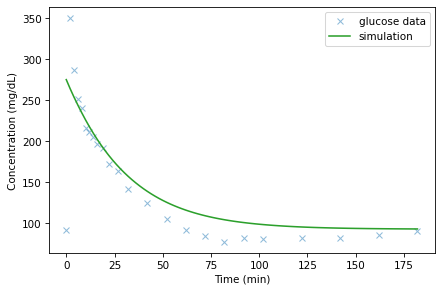

In [13]:
data.glucose.plot(style='x', alpha=0.5, label='glucose data')
results.G.plot(style='-', color='C2', label='simulation')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

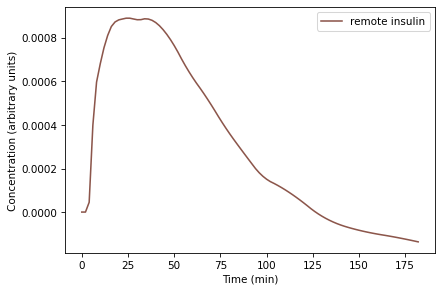

In [14]:
results.X.plot(color='C5', label='remote insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration (arbitrary units)')

Solving Differential Equations

In [15]:
def slope_func(t, state, system):
    G, X = state
    X1, na, nb, nc = system.params
    I, id, gd = system.I, system.id, system.gd
    dGdt = -na * (G - gd) - X*G
    dXdt = nc * (I(t) - id) - nb * X

    return dGdt, dXdt

In [16]:
results2, details = run_solve_ivp(system, slope_func,
                                  t_eval=results.index)

In [17]:
details.success

True

In [18]:
details.message

'The solver successfully reached the end of the integration interval.'

In [19]:
results2.head()

,G,X
0.0,275.000000,0.000000
2.0,264.339078,0.000020
4.0,254.256203,0.000210
6.0,244.637045,0.000473
8.0,235.491115,0.000613


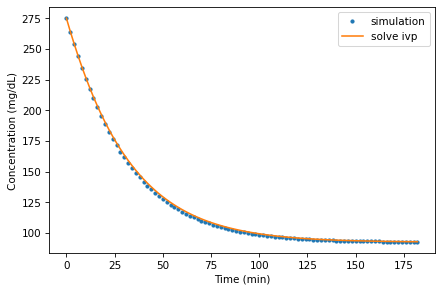

In [20]:
results.G.plot(style='.', label='simulation')
results2.G.plot(style='-', label='solve ivp')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [22]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff.abs().describe()

count    92.000000
mean      0.741499
std       0.458310
min       0.000000
25%       0.301590
50%       0.702756
75%       1.190168
max       1.418202
Name: G, dtype: float64

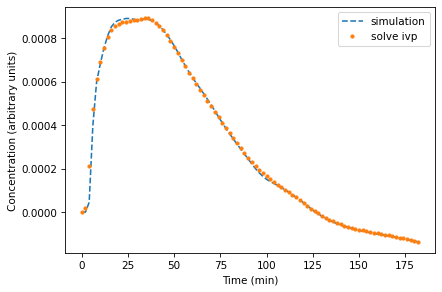

In [23]:
results.X.plot(style='--', label='simulation')
results2.X.plot(style='.', label='solve ivp')
decorate(xlabel='Time (min)',
         ylabel='Concentration (arbitrary units)')

In [24]:
diff = results.G - results2.X
percent_diff = diff / results2.X * 100
percent_diff.abs().describe()

count    9.200000e+01
mean              inf
std               NaN
min      1.619846e+07
25%      2.156538e+07
50%      5.331326e+07
75%      1.073370e+08
max               inf
dtype: float64

**Exercises**

Exercise 1

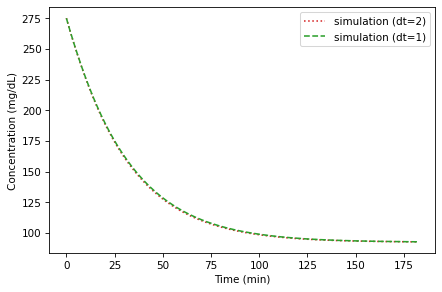

In [25]:
system_ex = system.set(dt = 1)
results_ex = run_simulation(system_ex, update_func)
results.G.plot(style='C3:', label='simulation (dt=2)')
results_ex.G.plot(style='C2--', label='simulation (dt=1)')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [27]:
diff = results.G - results_ex.G
percent_diff = diff / results_ex.G * 100
percent_diff.abs().describe()

count    92.000000
mean      0.384385
std       0.239481
min       0.000000
25%       0.155560
50%       0.361916
75%       0.620987
max       0.742986
Name: G, dtype: float64